# Анализ оттока клиентов для сети фитнес-центров «Культурист-датасаентист»

Заказчик хочет знать, какие факторы влияют на отток клиентов, чтобы на основе этого разработать более эффективную стратегию взаимодействия с пользователями. Считается, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.<br><br>
*Задача* — провести анализ и подготовить план действий по удержанию клиентов, а именно:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<br>
    1) выделить целевые группы клиентов;<br>
    2) предложить меры по снижению оттока;<br>
    3) определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
print('Количество дубликатов:', gym_churn.duplicated().sum())

Количество дубликатов: 0


В датафрейме нет пропусков, типы данных в порядке. Дубликатов не обнаружено. Однако следует перевести названия столбцов в нижний регистр. 

In [5]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.tail()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


## Исследовательский анализ данных (EDA)

In [6]:
# смотрим данные о среднем, стандартном отклонении и т.п.
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Отсутствующих признаков нет. Половина признаков представлена категориальными переменными.

In [7]:
# считаем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
gym_by_churn = gym_churn.groupby('churn').agg('mean')
gym_by_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Судя по средним значениям показателей для двух групп (те, кто ушёл, и те, кто остался) на отток скорее всего не влияет пол и наличие контактного телефона, т.к. значения средних по этим признакам почти равны. Остальные признаки в той или иной степени могут влиять на факт ухода клиента. 

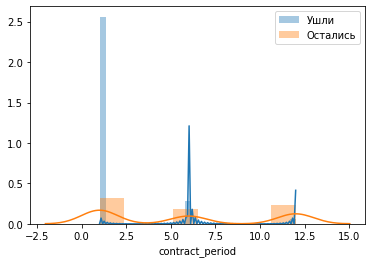

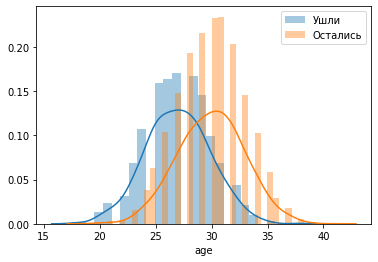

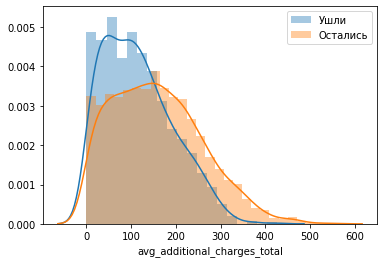

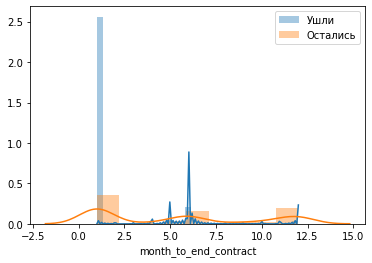

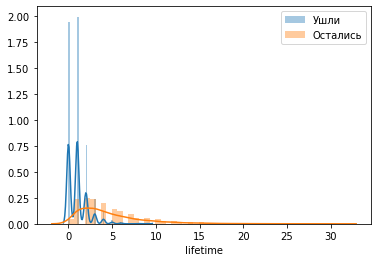

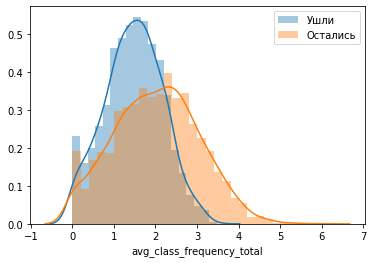

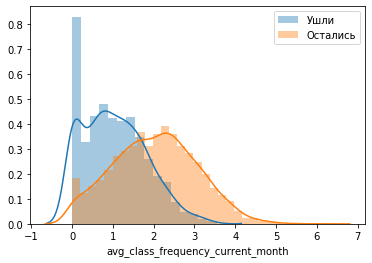

In [8]:
churn = gym_churn.query('churn == 1')
no_churn = gym_churn.query('churn == 0')

quant_cols = (['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract',
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month'])
for col in quant_cols:
    sns.distplot(churn[col])
    sns.distplot(no_churn[col])
    plt.legend(['Ушли', 'Остались'])
    plt.show()

Исходя из графиков, можно заключить, что по большинству количественных признаков две группы действительно различны. Как правило, распределения для второй группы ("остались") сдвинуты немного вправо относительно графиков первой группы ("ушли"). Более того, графики второй группы чаще напоминают стандартное распределение, чем графики первой.

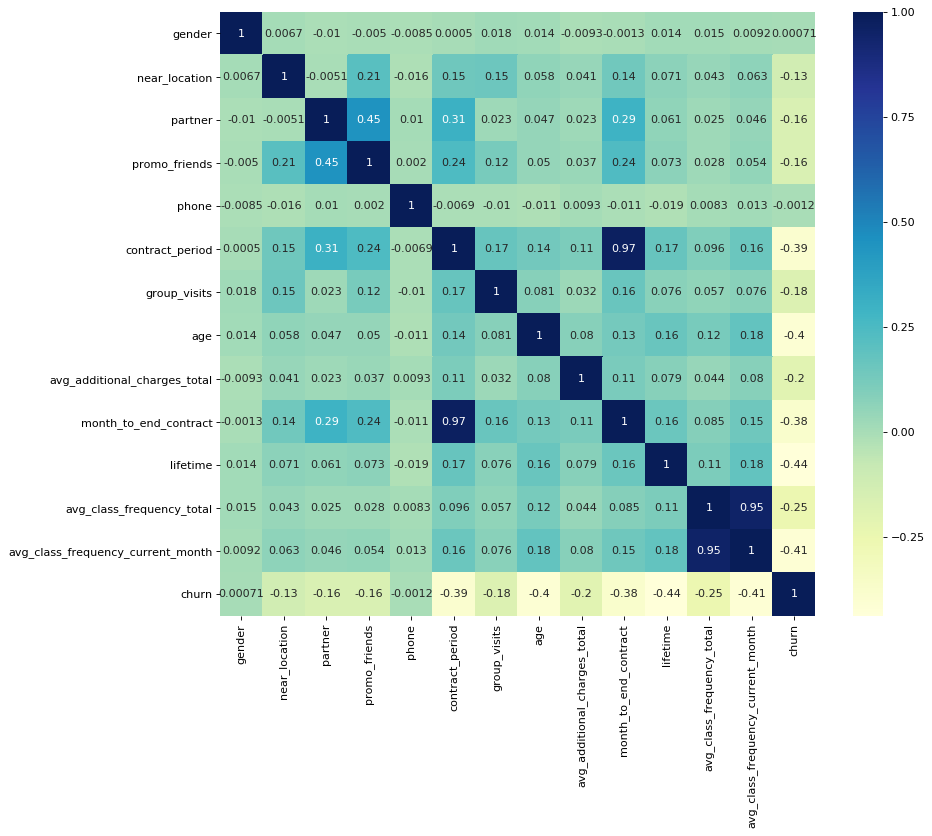

In [9]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(gym_churn.corr(), xticklabels=gym_churn.corr().columns, 
            yticklabels=gym_churn.corr().columns, cmap='YlGnBu', annot=True);

Сильно коррелируют следующие показатели:
- количество месяцев до окончания конктракта и срок его заключения,
- посещаемость занятий в текущем месяце и за весь год.

Также следует обратить внимание, что коэффициенты корреляции показателей с целевой переменной отрицательно. Это значит, что чем ниже показатель, тем больше вероятность, что клиент уйдёт. Это подтверждают и гистораммы, приведённые ранее.

## Модель прогнозирования оттока пользователей

In [10]:
# удалим признаки, которые сильно коррелируют между собой и мало коррелируют с целевой переменной
churn_no_corr = gym_churn.drop(['avg_class_frequency_current_month', 'month_to_end_contract'],
                              axis=1)

In [11]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = churn_no_corr.drop('churn', axis = 1)
y = churn_no_corr['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
# стандартизируем данные и обучаем scaler
scaler = StandardScaler()
scaler.fit(X_train)

# стандартизируем обучающую и тестовую выборку
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

In [13]:
# задаём алгоритм для логистической регрессии и обучаем её
model = LogisticRegression()
model.fit(X_train_st, y_train)
    
# делаем прогнозы
y_pred = model.predict(X_test_st)
prob = model.predict_proba(X_test_st)[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [15]:
print('Соотношение классов:\n', churn_no_corr['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


In [16]:
print_all_metrics(y_test, y_pred, prob)

Метрики классификации
Accuracy: 0.90
Precision: 0.79
Recall: 0.81


### Случайный лес

In [17]:
# задаём алгоритм для случайного леса, обучаем её и делаем предсказания
model_ens = RandomForestClassifier(n_estimators = 100)
model_ens.fit(X_train_st, y_train)

y_pred_ens = model_ens.predict(X_test_st)
prob_ens = model_ens.predict_proba(X_test_st)[:,1]

In [18]:
print_all_metrics(y_test, y_pred_ens, prob_ens)

Метрики классификации
Accuracy: 0.89
Precision: 0.80
Recall: 0.77


Метрики логистической регрессии (доля правильных ответов, точность и полнота) немного лучше, чем метрики случайного леса. В случае регрессии правильный прогноз был дан для 90% ответов.

## Кластеризация пользователей

In [19]:
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

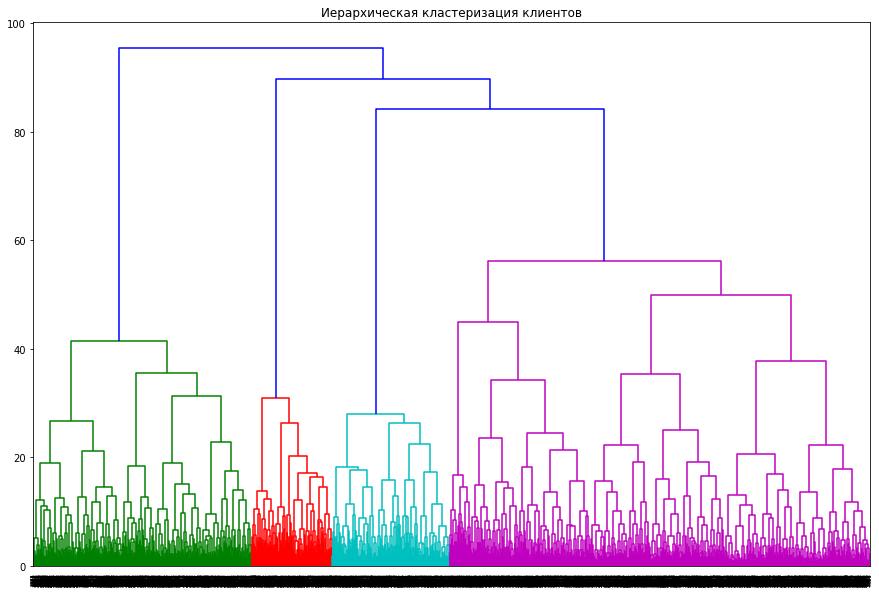

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show()

На графике видно, что в результате иерархической кластеризации были выделены 4 группы клиентов. Возьмём это количество кластеров для последующего анализа.

In [21]:
# обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов
km = KMeans(n_clusters = 4, random_state=0)
labels = km.fit_predict(X_sc)
gym_churn['cluster'] = labels

In [22]:
gym_churn.groupby('cluster').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.524599,1.000000,0.176893,0.061913,1.0,3.035931,0.394140,28.974019,143.390526,2.858485,3.334439,1.848948,1.707296,0.332781
1,0.490354,0.995981,0.941318,0.772508,1.0,7.787781,0.513666,29.663183,157.200280,7.069936,4.524920,1.979426,1.939666,0.106109
2,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619,0.399287
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


По средним значениям нельзя точно сказать, по какому принципу была проведена кластеризация.

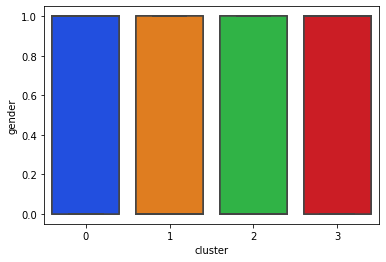

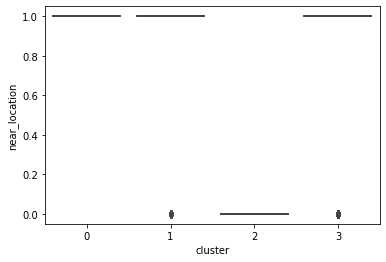

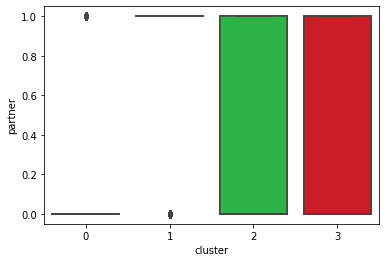

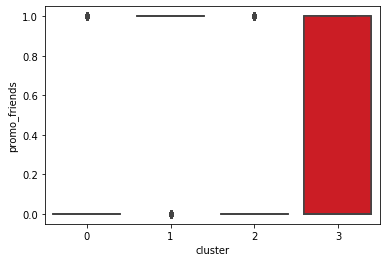

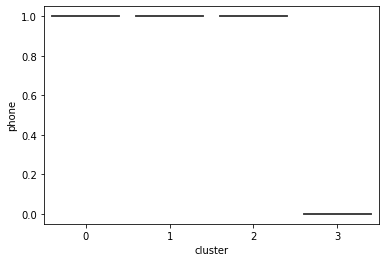

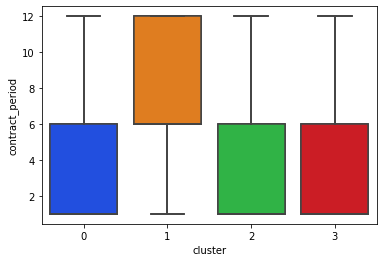

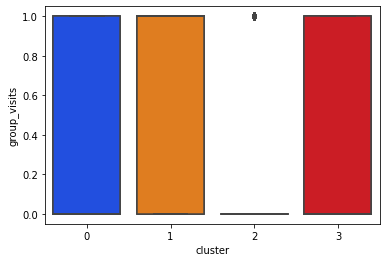

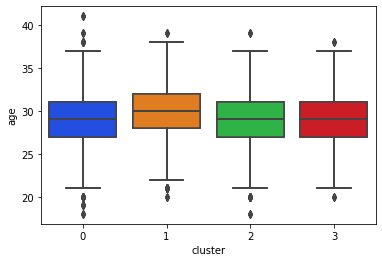

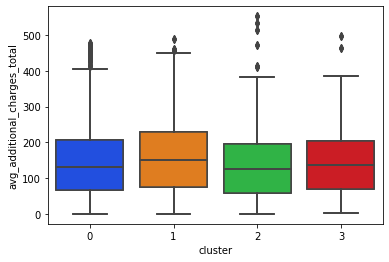

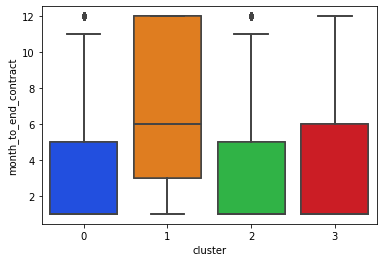

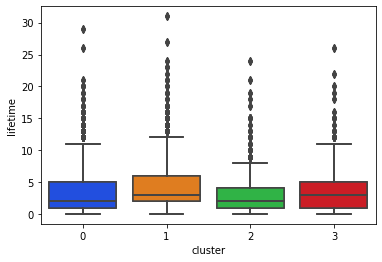

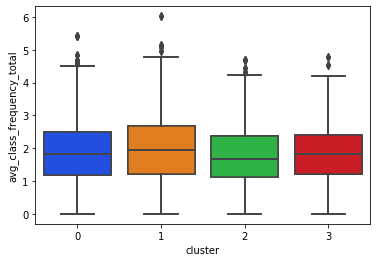

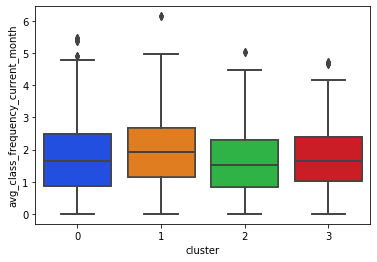

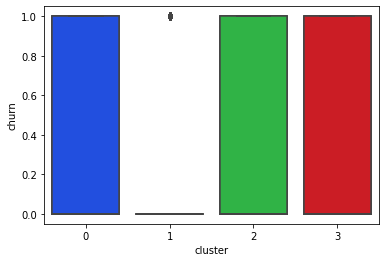

In [23]:
for feature in gym_churn.drop('cluster', axis=1).columns:
    for i in range(0,3):
        sns.boxplot(y = gym_churn[feature], x = gym_churn['cluster'], palette='bright')
    plt.show()

Почти на всех графиках выделяется группа 1, отток в которой минимален. В ней большинство клиентов:
- живут рядом,
- являются сотрудниками компаний-партнёров,
- использовали промо-код от знакомого при оплате первого абонемента,
- оставили свой телефон,
- заключили контракт более чем на 6 месяцев,
- старше клиентов из других кластеров,
- тратят больше на дополнительные услуги,
- дольше являются клиентами фитнес-центра и
- чаще посещают занятия.

In [24]:
clustered_gym = (gym_churn.groupby('cluster').agg({'churn':'sum', 'age': 'count'})
                 .rename(columns={'age': 'total'}))
clustered_gym['churn_share'] = (clustered_gym['churn'] / clustered_gym['total']).round(2)
clustered_gym

,churn,total,churn_share
cluster,,,
0,602,1809,0.33
1,132,1244,0.11
2,224,561,0.40
3,103,386,0.27


Наибольшая доля оттока наблюдается в группах 0 и 2, из которых ушли 33% и 40% клиентов соответственно. Наиболее лояльной оказалась группа 1 (11% оттока).

Группа 2 выделяется среди остальных тем, что в ней клиенты:
- живут далеко от фитнес-центра и
- не посещают групповые занятия.

## Выводы

Была разработана модель машинного обучения (логистическая регрессия) для предсказания оттока клиентов, которая показывает точность ответа 90%. Также была проведена кластеризация, с помощью которой удалось выявить 4 группы клиентов с разной долей оттока, от самой низкой до самой высокой (11-40%). На основе полученных результатов, можно предложить следующие меры по снижению оттока:
1. Расширить сеть компаний-партнёров
2. Разместить наружную рекламу или запустить таргетированную рекламу для жителей района, в котором находится фитнес-центр
3. Сделать групповые занятия более привлекательными для клиентов (пересмотреть программу, повысить информированность, проработать удобное расписание)
4. Сделать скидки (или другие выгодные предложения) для тех, кто заключает контракт на 6+ месяцев
5. Поработать над бонусами для тех, кто приводит друзей